# Detección de anomalías en datos de temperatura de motor eléctrico

## Objetivo general

Determinar un valor proximado para activar de una alarma de temperatura para el equipo monitoreado.

### Objetivos específicos

- Realizar un analisis descriptivo de la data de temperatura
- Encontrar anomalias usando metodos estadisticos
- Encontrar anomalias usando algoritmos de ML no supervisado como LOF, K-means.
- Comparar los resultados de los modelos





**Descripción de los datos**: El dataset corresponde un archivo CSV con los datos recopilados por un sensor de temperatura conectada a la carcasa de un motor eléctrico en una fábrica, el sensor transmite datos cada 10 minutos aproximadamente.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from scipy.spatial.distance import cdist
# import mad model from pyod
from pyod.models.mad import MAD
# import lof model from pyod
from pyod.models.lof import LOF
# Set the aesthetic style of the plots
sns.set_style("whitegrid")


In [2]:
temperature_data = pd.read_csv('temperature.csv')
temperature_data.head()

,timestamp,created_at_channel_2,context_channel_2,channel_2,date (Asia/Jerusalem)
0,1698769885256,1698769885256,{},55.00,2023-10-31 18:31:25.256000+02:00
1,1698769163466,1698769163466,{},56.68,2023-10-31 18:19:23.466000+02:00
2,1698768441502,1698768441502,{},58.37,2023-10-31 18:07:21.502000+02:00
3,1698767719494,1698767719494,{},60.31,2023-10-31 17:55:19.494000+02:00
4,1698766997245,1698766997245,{},62.62,2023-10-31 17:43:17.245000+02:00


In [3]:
temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3177 entries, 0 to 3176
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              3177 non-null   int64  
 1   created_at_channel_2   3177 non-null   int64  
 2   context_channel_2      3177 non-null   object 
 3   channel_2              3177 non-null   float64
 4   date (Asia/Jerusalem)  3177 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 124.2+ KB


In [4]:
temperature_data['channel_2'].describe()

count    3177.000000
mean       52.247280
std        25.143497
min        20.560000
25%        30.250000
50%        39.370000
75%        83.180000
max        94.750000
Name: channel_2, dtype: float64

In [5]:
temperature_data.shape[0]

3177

Existen 3177 lecturas capturadas por el sensor y se observa que temperatura fluctúa entre 20.5 y 94.75 grados Celcius.

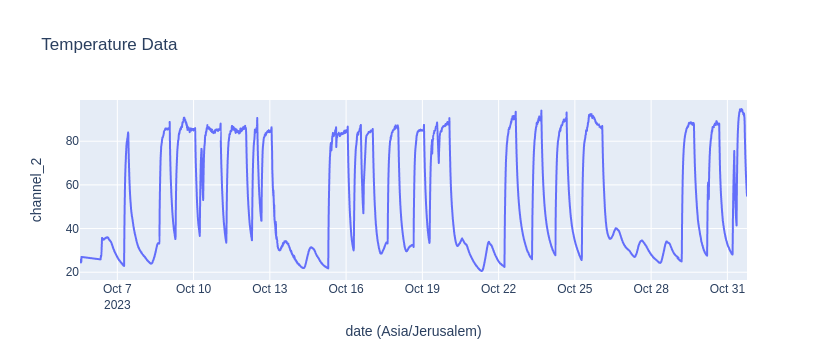

In [30]:
# plot the data for channel 2 using plotly express
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperature Data')
fig.show()


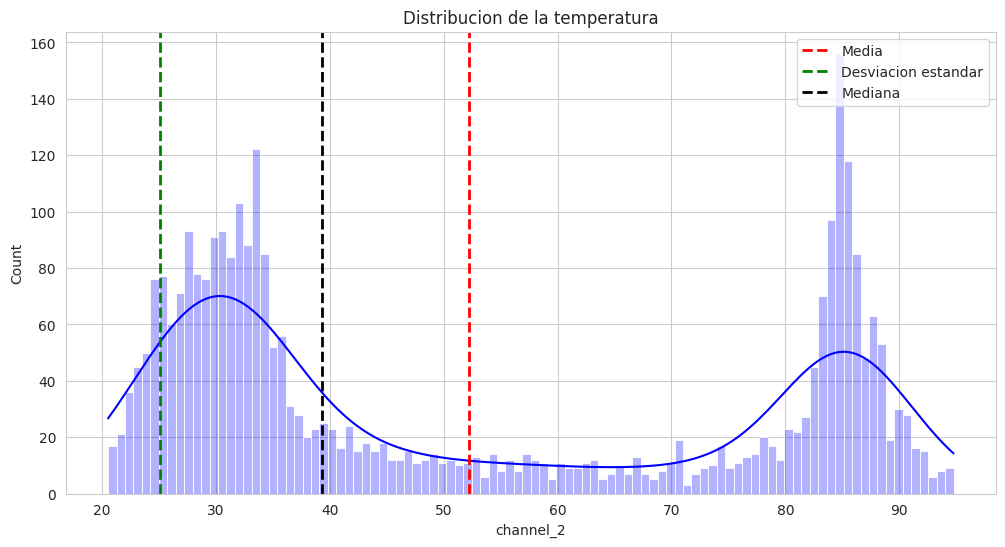

In [7]:
# Plot the distribution of `temperature` readings and also the mean and median
plt.figure(figsize=(12,6))
plt.title('Distribucion de la temperatura')
sns.histplot(data=temperature_data['channel_2'], kde=True, bins=100, color='blue', alpha=0.3)
plt.axvline(temperature_data['channel_2'].mean(), color='red', linestyle='dashed', linewidth=2, label="Media")
plt.axvline(temperature_data['channel_2'].std(), color='green', linestyle='dashed', linewidth=2, label="Desviacion estandar")
plt.axvline(temperature_data['channel_2'].median(), color='black', linestyle='dashed', linewidth=2, label="Mediana")
plt.legend()
plt.show()




### Indetificando tendencias en los datos usando `seasonal_decompose`



Aca se puede descomponer la señal en la data original, la estacionalidad o seasonality, la tendencia o trend y un residuo que puede corresponder al ruido dentro de la señal. Para datos horarios, 24 podría ser un buen punto de partida para la frecuencia de descomposición estacional.

In [8]:
decompose_frequency = 24
decomposition = seasonal_decompose(temperature_data['channel_2'], period=decompose_frequency, model='additive', extrapolate_trend='freq')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [9]:
#plot the decomposition using plotly express and showing the trend, seasonal and residual components using the timestamp as the x-axis
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperature Data')
fig.add_scatter(x=temperature_data['date (Asia/Jerusalem)'], y=trend, mode='lines', name='Trend')
fig.add_scatter(x=temperature_data['date (Asia/Jerusalem)'], y=seasonal, mode='lines', name='Seasonal')
fig.add_scatter(x=temperature_data['date (Asia/Jerusalem)'], y=residual, mode='lines', name='Residual')
fig.show()




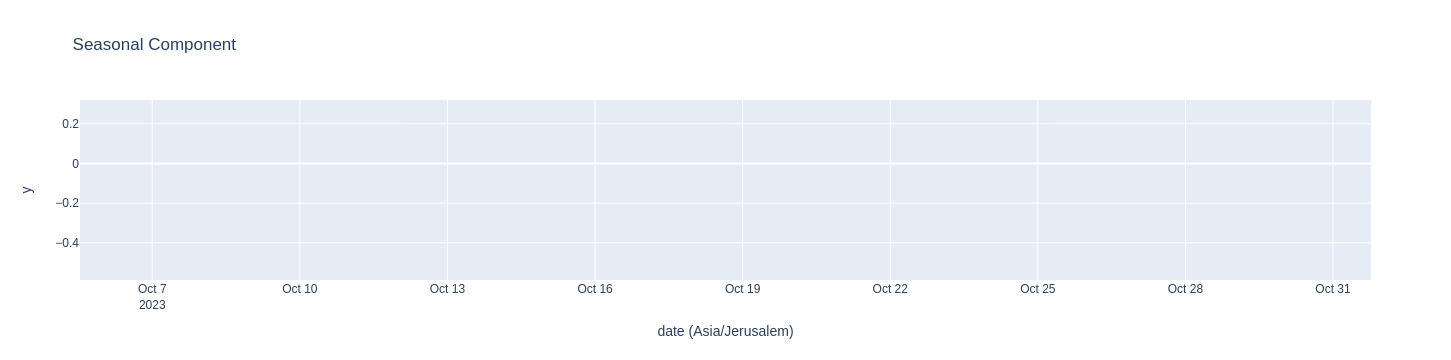

In [10]:
# plot the seasonal component using plotly express
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y=seasonal, title='Seasonal Component')
fig.show()

## Algoritmos para detección de anomalías usando metodos estadísticos

#### MAD 

El algoritmo de desviación media absoluta (MAD) es un método sólido para detectar anomalías en los datos. Es particularmente útil cuando los datos contienen valores atípicos que podrían sesgar la media y la desviación estándar. El MAD es menos sensible a los valores atípicos en un conjunto de datos que la desviación estándar, lo que lo convierte en una buena opción para la detección de anomalías en datos con valores atípicos.

Los pasos para utilizar el modelo MAD para la detección de anomalías son los siguientes:

- **Calcular la mediana:** Encuentre la mediana de los datos, que sirve como una medida sólida de tendencia central.
- **Calcular la desviación absoluta de la mediana**: Calcule la diferencia absoluta de la mediana para cada dato. 
- **Calcule la MAD:** La MAD es la mediana de estas desviaciones absolutas.
- **Identificar anomalías:** Los puntos de datos que tienen una desviación de la mediana que está a una cierta cantidad de MAD de la mediana se clasifican como anomalías. Un umbral común es 3 o más MAD.


In [11]:
median = np.median(temperature_data['channel_2'])
print(median)
# Calculate the absolute deviations from the median
absolute_deviation = np.abs(temperature_data['channel_2'] - median)
# Calculate the MAD
mad = np.median(absolute_deviation)
print(mad)
# Define a threshold for identifying outliers (commonly 3 MADs)
threshold = 3 * mad
print(threshold)
# Identify anomalies (data points that are more than 3 MADs away from the median)
mad_anomalies = absolute_deviation > threshold

# Add MAD anomaly labels to the DataFrame (-1 for anomalies, 1 for normal)
temperature_data['mad_anomaly'] = mad_anomalies.astype(int).replace({0: 1, 1: -1})
mad_anomalies_data = temperature_data[temperature_data['mad_anomaly'] == -1]

mad_anomalies_count = mad_anomalies_data.shape[0]
print(mad_anomalies_count)
mad_anomalies_count_percentage = mad_anomalies_count  / temperature_data.shape[0]
print('MAD anomalies count percentage: ', mad_anomalies_count_percentage)


39.37
14.059999999999999
42.17999999999999
886
MAD anomalies count percentage:  0.2788794460182562


El modelo de Desviación Absoluta Mediana (MAD) ha identificado 886 anomalías en los datos de temperatura, que están resaltadas en rojo en el gráfico. Este número relativamente alto de anomalías sugiere que el umbral establecido (3 MAD de distancia de la mediana) podría estar capturando una porción significativa de los datos como valores atípicos.

Es importante tener en cuenta que la elección del umbral en la detección de anomalías influye en gran medida en la cantidad de anomalías detectadas. Un umbral menos estricto (p. ej., 2 MAD) daría como resultado menos anomalías detectadas, mientras que un umbral más estricto (p. ej., 4 MAD) detectaría menos anomalías y más extremas.

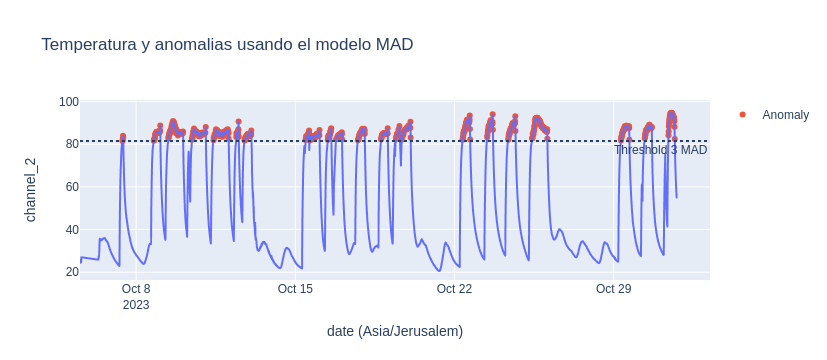

In [12]:

fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperatura y anomalias usando el modelo MAD')
fig.add_scatter(x=mad_anomalies_data['date (Asia/Jerusalem)'], y=mad_anomalies_data['channel_2'], mode='markers', name='Anomaly')
fig.add_hline(y=(threshold + median), line_dash="dot", annotation_text="Threshold 3 MAD", annotation_position="bottom right")
fig.show()


In [13]:
# implement the mad model from pyod
mad_model = MAD(threshold=2)
# fit the model to the data
mad_model.fit(temperature_data[['channel_2']])
# get the labels for the data
mad_labels = mad_model.labels_
# get the outlier scores
mad_scores = mad_model.decision_scores_
# add the labels and scores to the data frame
temperature_data['mad_labels'] = mad_labels
temperature_data['mad_scores'] = mad_scores
# get the anomalies
mad_anomalies_data = temperature_data[temperature_data['mad_labels'] == 1]
# get the anomaly count
mad_anomalies_count = mad_anomalies_data.shape[0]
print(mad_anomalies_count)
# get the anomaly count percentage
mad_anomalies_count_percentage = mad_anomalies_count  / temperature_data.shape[0]
print('MAD anomalies count percentage: ', mad_anomalies_count_percentage)



903
MAD anomalies count percentage:  0.2842304060434372


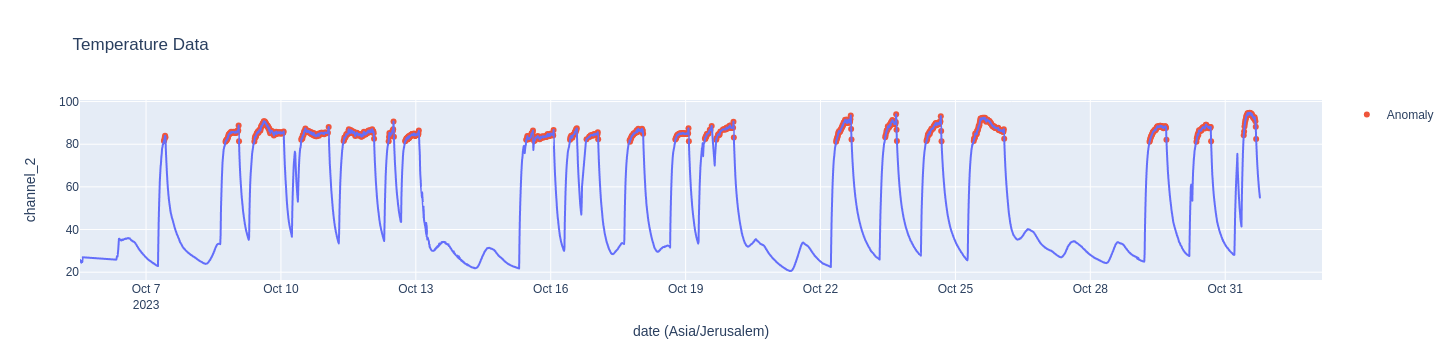

In [14]:
# plot the data for channel 2 using plotly express and the anomalies found using the MAD model form pyod
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperature Data')
fig.add_scatter(x=mad_anomalies_data['date (Asia/Jerusalem)'], y=mad_anomalies_data['channel_2'], mode='markers', name='Anomaly')
fig.show()

### Z-score

Medida estadística que describe la relación de un punto de datos con la media de un grupo de valores, medida en términos de desviaciones estándar de la media. Se usa comúnmente en la detección de anomalías para identificar valores atípicos.

Los pasos para utilizar el método Z-score para detectar anomalías son los siguientes:

- Calcular la media y la desviación estándar: Media y la desviación estándar de los datos de temperatura.
- Calcule el Z-score: Para cada punto de datos, calcule la puntuación Z, que es el número de desviaciones estándar que tiene un punto de datos de la media.
- Identificar anomalías: Los puntos de datos con una puntuación Z que excede un cierto umbral (comúnmente 2 o 3) se consideran anomalías.


In [15]:

mean = temperature_data['channel_2'].mean()
std_dev = temperature_data['channel_2'].std()

# Calculate the Z-scores for each data point
z_scores = (temperature_data['channel_2'] - mean) / std_dev

# Define a threshold for identifying outliers (commonly 3)
z_score_threshold = 1.5

# Identify anomalies (data points that have a Z-score greater than the threshold)
z_score_anomalies = np.abs(z_scores) > z_score_threshold

# Add Z-score anomaly labels to the DataFrame (-1 for anomalies, 1 for normal)
temperature_data['z_score_anomaly'] = z_score_anomalies.astype(int).replace({0: 1, 1: -1})

# Plotting the results
# Anomalies identified by Z-score
z_score_anomalies_data = temperature_data[temperature_data['z_score_anomaly'] == -1]

# Count the number of anomalies detected by Z-score
z_score_anomalies_count = z_score_anomalies_data.shape[0]



In [16]:
print(z_score_anomalies_count)
zcore_anomalies_count_percentage = z_score_anomalies_count  / temperature_data.shape[0]
print('Z-score anomalies count percentage: ', zcore_anomalies_count_percentage)

94
Z-score anomalies count percentage:  0.029587661315706643


In [27]:

# Plot the data for channel 2 using the z score and using plotly express
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperatura y anomalias usando Z-score')
fig.add_scatter(x=z_score_anomalies_data['date (Asia/Jerusalem)'], y=z_score_anomalies_data['channel_2'], mode='markers', name='Anomaly')
fig.add_hline(y=mean + z_score_threshold * std_dev, line_dash="dot", annotation_text="Threshold 1.5 STD's", annotation_position="bottom right")
fig.show()


## Identificando anomalias con modelos de ML no supervisados

### LOF
El algoritmo del factor de valores atípicos locales (LOF) es un método de detección de anomalías no supervisado que funciona midiendo la desviación local de un punto determinado con respecto a sus vecinos. Se supone que los puntos atípicos tienden a estar aislados de los puntos normales.

In [18]:
X = temperature_data['channel_2'].values.reshape(-1,1)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
y_pred = lof.fit_predict(X)
temperature_data['outlier'] = y_pred
anomalies = temperature_data.loc[temperature_data['outlier'] == -1]
anomalies_count = anomalies.shape[0]
print('Anomalies count using LOF: ', anomalies_count)
anomalies_count_percentage = anomalies_count  / temperature_data.shape[0]
print('Anomalies count percentage usinf LOF: ', anomalies_count_percentage -1 )

Anomalies count using LOF:  36
Anomalies count percentage usinf LOF:  -0.9886685552407932


In [19]:
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperatura con Anomalías encontradas usando el algoritmo LOF')
fig.add_scatter(x=anomalies['date (Asia/Jerusalem)'], y=anomalies['channel_2'], mode='markers', name='Anomalies')
fig.show()

## K means
Aunque no es específicamente un algoritmo de detección de anomalías, K-Means se puede utilizar para identificar valores atípicos al encontrar las distancias de los puntos de datos desde el centroide del grupo más cercano.

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

# Calculate the distances of each data point from the cluster centroids
distances = cdist(X_scaled, centroids, 'euclidean')

# Get the minimum distance to a centroid for each data point
min_distances = distances.min(axis=1)

# Label data points as anomalies if their distance to the nearest cluster centroid is in the top 5%
threshold = pd.Series(min_distances).quantile(0.95)
kmeans_anomaly_labels = (min_distances > threshold).astype(int)

# Add the KMeans anomaly labels to the DataFrame (-1 for anomalies, 1 for normal)
temperature_data['kmeans_anomaly'] = pd.Series(kmeans_anomaly_labels).replace({0: 1, 1: -1})

# Get the anomaly data
kmeans_anomalies = temperature_data.loc[temperature_data['kmeans_anomaly'] == -1]
kmeans_anomalies_count = kmeans_anomalies.shape[0]
print('KMeans anomalies count: ', kmeans_anomalies_count)
kmeans_anomalies_count_percentage = kmeans_anomalies_count / temperature_data.shape[0]
print('KMeans anomalies count percentage: ', kmeans_anomalies_count_percentage)



KMeans anomalies count:  159
KMeans anomalies count percentage:  0.05004721435316336


/home/david/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [21]:
# Plot the temperature readings with anomalies marked using KMeans clustering
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperatura con Anomalías encontradas usando el algoritmo KMeans')
fig.add_scatter(x=temperature_data.loc[temperature_data['kmeans_anomaly'] == -1]['date (Asia/Jerusalem)'], y=temperature_data.loc[temperature_data['kmeans_anomaly'] == -1]['channel_2'], mode='markers', name='Anomalies')
fig.show()


In [22]:
# implement the one class SVM model from pyod
ocsvm_model = OneClassSVM(nu=0.01)
# fit the model to the data
ocsvm_model.fit(temperature_data[['channel_2']])
# get the labels for the data
ocsvm_labels = ocsvm_model.predict(temperature_data[['channel_2']])
# get the outlier scores
ocsvm_scores = ocsvm_model.decision_function(temperature_data[['channel_2']])
# add the labels and scores to the data frame
temperature_data['ocsvm_labels'] = ocsvm_labels
temperature_data['ocsvm_scores'] = ocsvm_scores
# get the anomalies
ocsvm_anomalies_data = temperature_data[temperature_data['ocsvm_labels'] == -1]
# get the anomaly count
ocsvm_anomalies_count = ocsvm_anomalies_data.shape[0]
print(ocsvm_anomalies_count)
# get the anomaly count percentage
ocsvm_anomalies_count_percentage = ocsvm_anomalies_count  / temperature_data.shape[0]
print('OCSVM anomalies count percentage: ', ocsvm_anomalies_count_percentage)


54
OCSVM anomalies count percentage:  0.0169971671388102


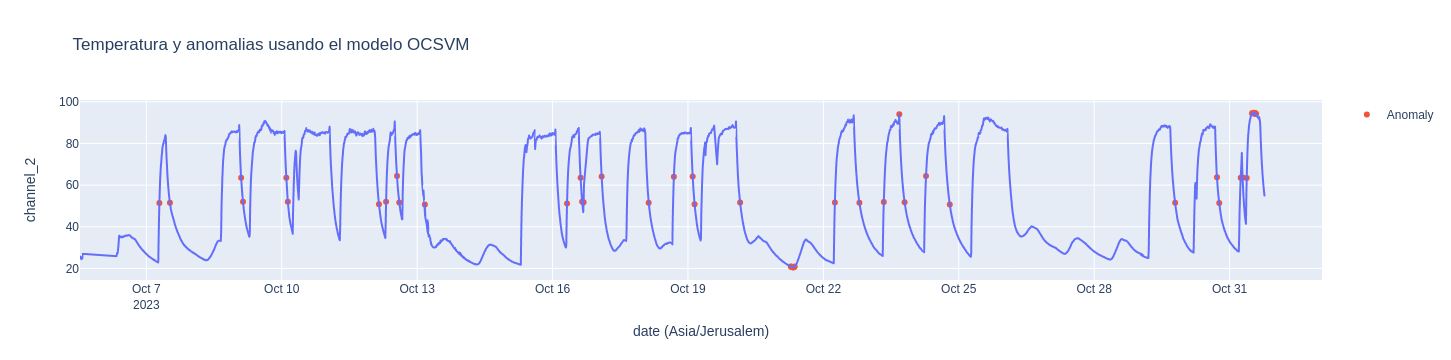

In [23]:
#plot the data for channel 2 using plotly express and the anomalies found using the OCSVM model form pyod
fig = px.line(temperature_data, x='date (Asia/Jerusalem)', y='channel_2', title='Temperatura y anomalias usando el modelo OCSVM')
fig.add_scatter(x=ocsvm_anomalies_data['date (Asia/Jerusalem)'], y=ocsvm_anomalies_data['channel_2'], mode='markers', name='Anomaly')
fig.show()


In [24]:
ocsvm_anomalies_data['channel_2'].describe()

count    54.000000
mean     55.935926
std      23.661459
min      20.560000
25%      50.870000
50%      51.840000
75%      64.090000
max      94.750000
Name: channel_2, dtype: float64

In [25]:

anomaly_counts = pd.DataFrame(
    {
        'Model': ['MAD', 'Z-Score', 'LOF', 'KMeans', 'OCSVM'], 
        'Anomaly Count': [mad_anomalies_count, z_score_anomalies_count, anomalies_count, kmeans_anomalies_count, ocsvm_anomalies_count], 
        'Min': [
                    mad_anomalies_data['channel_2'].min(), 
                    z_score_anomalies_data['channel_2'].min(), 
                    anomalies['channel_2'].min(), kmeans_anomalies['channel_2'].min(), 
                    ocsvm_anomalies_data['channel_2'].min()
                ], 
        'Max': [
                    mad_anomalies_data['channel_2'].max(), 
                    z_score_anomalies_data['channel_2'].max(), 
                    anomalies['channel_2'].max(), 
                    kmeans_anomalies['channel_2'].max(), 
                    ocsvm_anomalies_data['channel_2'].max()
                ]
    }
)
anomaly_counts

,Model,Anomaly Count,Min,Max
0,MAD,903,81.12,94.75
1,Z-Score,94,90.00,94.75
2,LOF,36,21.50,84.25
3,KMeans,159,55.12,94.75
4,OCSVM,54,20.56,94.75


/tmp/ipykernel_6757/2034440375.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



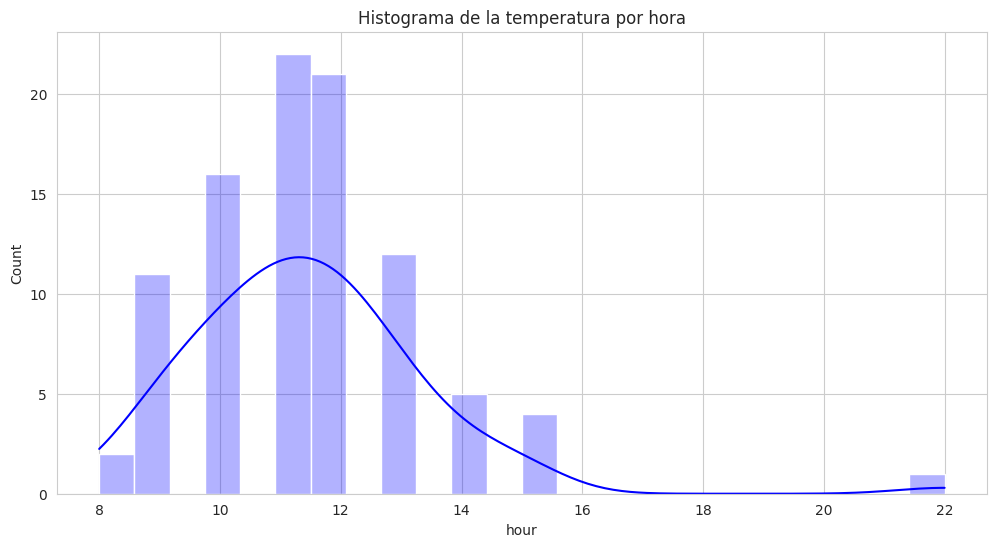

In [29]:
# determine the hour of the day for each reading and show a histogram of the readings by hour
z_score_anomalies_data['date (Asia/Jerusalem)'] = pd.to_datetime(z_score_anomalies_data['date (Asia/Jerusalem)'], utc = True)
temperature_data['hour'] = z_score_anomalies_data['date (Asia/Jerusalem)'].dt.hour
plt.figure(figsize=(12,6))
plt.title('Histograma de la temperatura por hora')
sns.histplot(data=temperature_data['hour'], kde=True, bins=24, color='blue', alpha=0.3)
plt.show()
